In [12]:
from __future__ import annotations
import numpy as np
import itertools
from multiprocessing import Pool
from tqdm import tqdm
import pandas as pd
from scipy.optimize import linprog
from typing import Dict, List, Optional, Tuple, Iterable
from scipy.optimize import linprog
import sys
import os
import matplotlib.pyplot as plt
import time

sys.path.append('../')

from geobin import Region, Tree, RegionTree, TreeNode

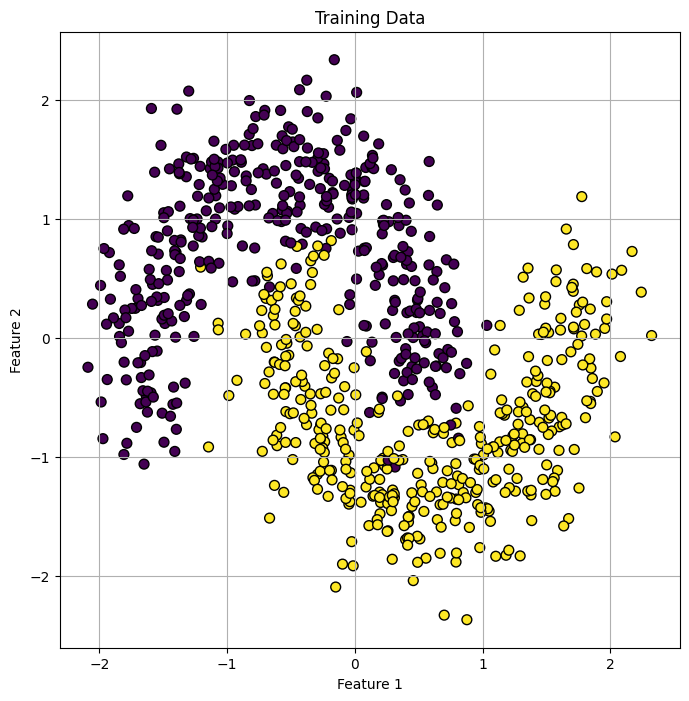

In [13]:
from src_experiment import get_moons_data, train_model, NeuralNet
train, test = get_moons_data(feature_noise=.2)
all_features = []
all_labels = []

for features, labels in train:
    all_features.append(features.detach().cpu())
    all_labels.append(labels.detach().cpu())

# Combine batches into one large array
import torch
X = torch.cat(all_features, dim=0).numpy()
y = torch.cat(all_labels, dim=0).numpy()

plt.figure(figsize=(8,8))

# 3. Plot using the first two columns (dimensions) of the features
# X[:, 0] is Feature 1, X[:, 1] is Feature 2
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)

plt.title("Training Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

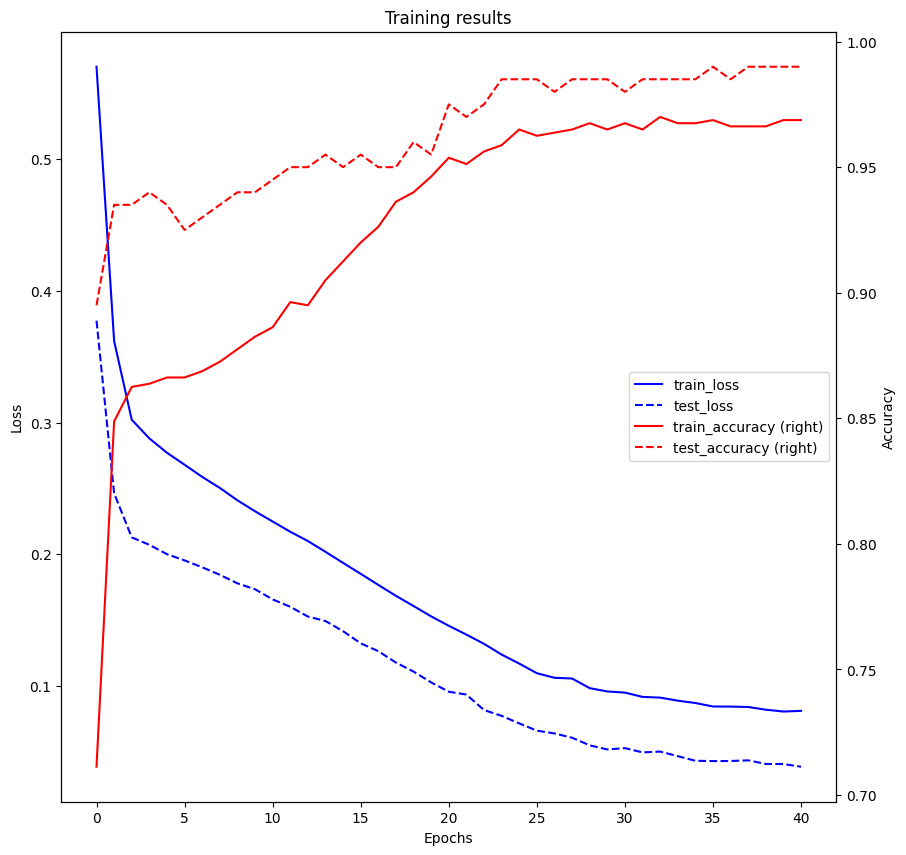

In [ ]:
from visualization import plot_training
from src_experiment import get_test_data
hidden_sizes = [0,5,5,5,1]

ActNet = NeuralNet(
    input_size = 2,
    hidden_sizes = hidden_sizes[1:-1],
    num_classes=1,
    seed=3,
)

res, = train_model(ActNet, train, test, epochs=41, save_everyth_epoch=10, SAVE_STATES=True, savepath=get_test_data())
plot_training(res)

In [15]:
trees = {}
tot_start = time.time()
for epoch in [0,10,20,30,40]:
    state_dict_path = get_test_data() / "state_dicts" / f"epoch{epoch}.pth"
    state = torch.load(state_dict_path)
    start = time.time()
    print(f"\n--- Epoch {epoch} ---")
    tree = Tree(state)
    tree.construct_tree(verbose=True)
    trees[epoch] = tree
    end = time.time()
    print(f"Duration: {end-start:.2f} s")
tot_end = time.time()
print(f"Total duration: {tot_end-tot_start:.2f} s")


--- Epoch 0 ---


Duration: 8.52 s

--- Epoch 10 ---


Duration: 8.66 s

--- Epoch 20 ---


Duration: 10.01 s

--- Epoch 30 ---


Duration: 10.03 s

--- Epoch 40 ---


Duration: 9.75 s
Total duration: 46.98 s


In [16]:
#suitable up to a [6,6,6] hidden layer configuration

# oldtrees = {}
# tot_start = time.time()
# for epoch, state in states.items():
#     start = time.time()
#     print(f"\n--- Epoch {epoch} ---")
#     tree = RegionTree(state)
#     tree.build_tree()
#     oldtrees[epoch] = tree
#     end = time.time()
#     print(f"Duration: {end-start:.2f} s")
# tot_end = time.time()
# print(f"Total duration: {tot_end-tot_start:.2f} s")

# Investigate trees

In [26]:
import itertools
t0 = trees[0]
# ot0 = oldtrees[0]
n_theo_all = 2**np.cumsum(np.array(hidden_sizes))

# prev_layer_nodes = [ot0.root]
for i in range(t0.L):
    # old_nodes = []
    # old_nodes.extend(itertools.chain.from_iterable([n.get_children() for n in prev_layer_nodes]))
    n_new = len(t0.get_regions_at_layer(i+1))
    # n_old = len(old_nodes)
    n_theo = n_theo_all[i+1]
    
    print(f"\nLayer: {i+1}\nRegions (new): {n_new}\nRegions (tot): {n_theo}\n")
    # print(f"\nLayer: {i+1}\nRegions (new): {n_new}\nRegions (old): {n_old}\nRegions (tot): {n_theo}\n")
    # prev_layer_nodes = old_nodes
    


Layer: 1
Regions (new): 29
Regions (tot): 128


Layer: 2
Regions (new): 101
Regions (tot): 16384


Layer: 3
Regions (new): 1130
Regions (tot): 2097152


Layer: 4
Regions (new): 1614
Regions (tot): 4194304



# Visualization

(<Figure size 1500x1200 with 20 Axes>,
 array([[<Axes: title={'center': 'Epoch 0'}, ylabel='Layer 1'>,
         <Axes: title={'center': 'Epoch 10'}>,
         <Axes: title={'center': 'Epoch 20'}>,
         <Axes: title={'center': 'Epoch 30'}>,
         <Axes: title={'center': 'Epoch 40'}>],
        [<Axes: ylabel='Layer 2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='Layer 3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='Layer 4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
       dtype=object))

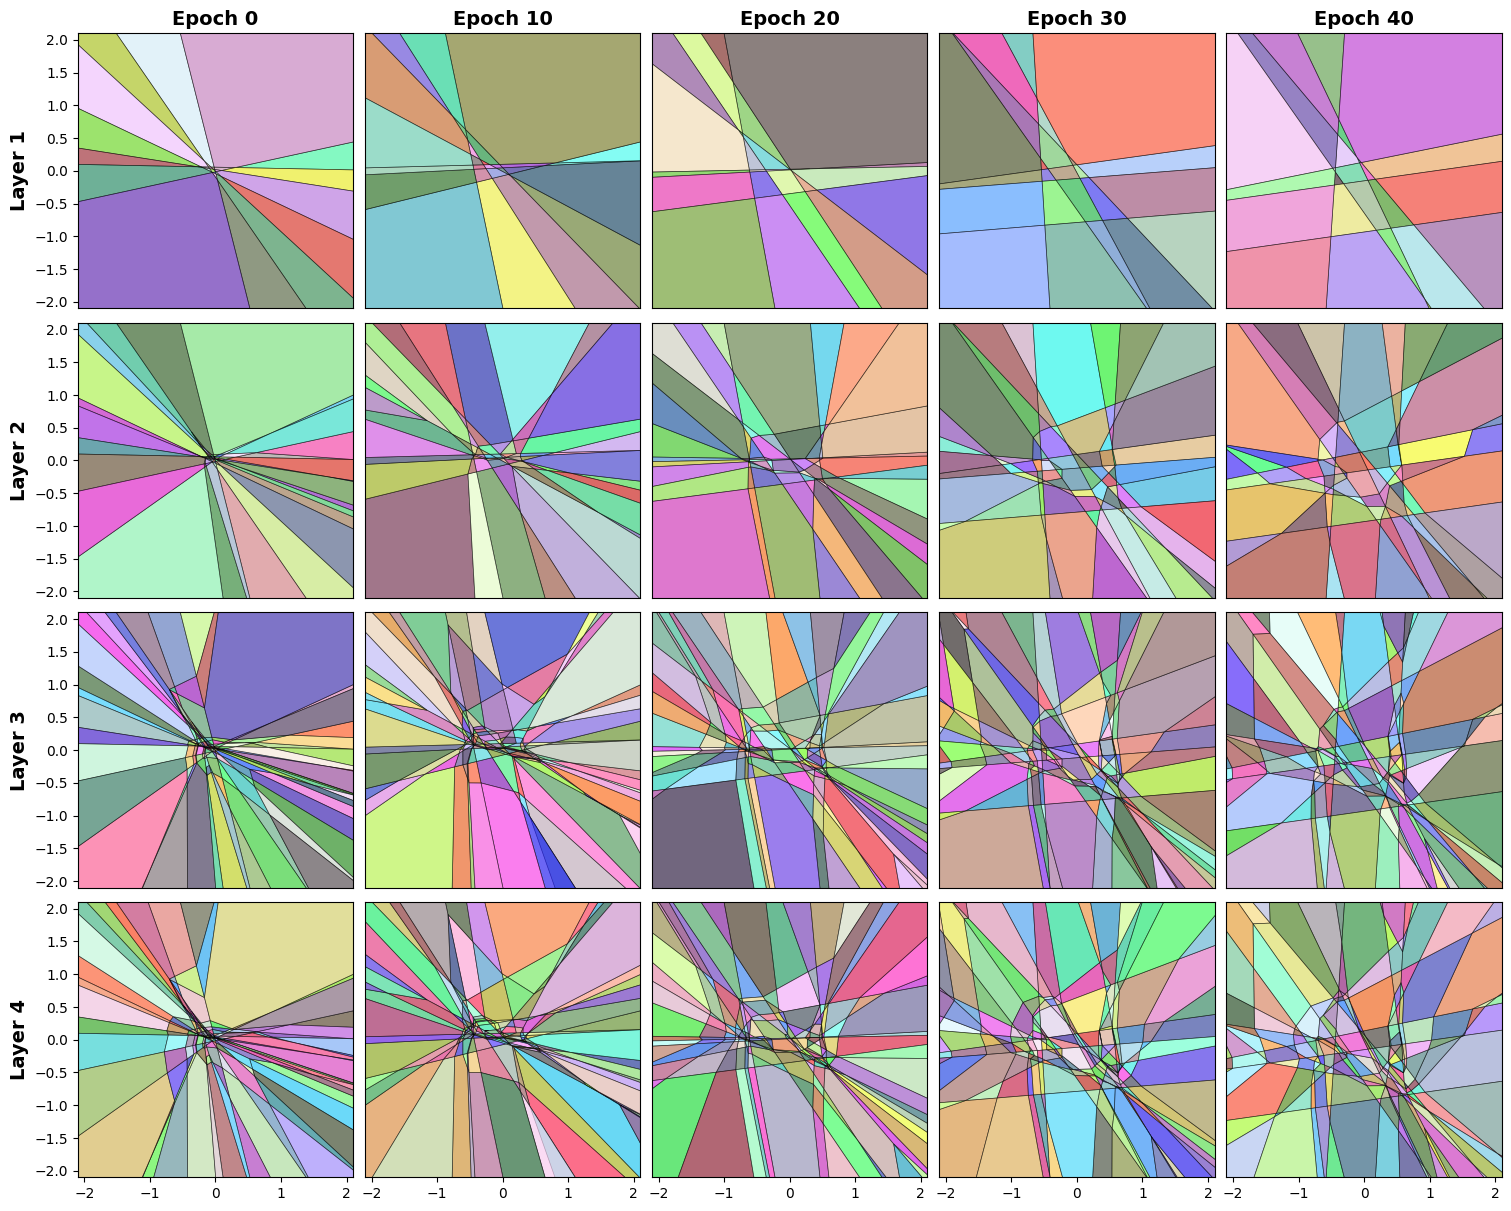

In [21]:
from visualization import plot_epoch_layer_grid
plot_epoch_layer_grid(trees, bound=2.1)

In [19]:
import numpy as np
from scipy.optimize import linprog
from tqdm import tqdm

def get_chebyshev_center(A, b):
    """
    Finds the Chebyshev center of the polytope Ax <= b.
    This is the center of the largest ball inscribed in the polytope.
    """
    # Ensure b is flat
    b = b.flatten()
    dim = A.shape[1]
    
    # 1. Calculate norms of rows for the radius term
    norm_A = np.linalg.norm(A, axis=1)
    
    # 2. Setup Linear Program
    # Maximize radius 'r' subject to: a_i*x + ||a_i||*r <= b_i
    # Scipy minimizes, so we minimize -r.
    # Variables: [x_1, ..., x_d, r]
    
    # Objective: [0, ..., 0, -1]
    c = np.zeros(dim + 1)
    c[-1] = -1
    
    # Constraints: [A  |  norm_A] * [x, r] <= b
    A_ub = np.hstack([A, norm_A.reshape(-1, 1)])
    b_ub = b
    
    # Bounds: x is unbounded, r >= 0 (radius must be positive)
    bounds = [(None, None)] * dim + [(0, None)]
    
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
    
    if res.success:
        return res.x[:-1]  # Return just the coordinate part, ignore r
    return None

def check_overlaps(tree, layer_idx, tol=1e-6):
    """
    Checks for spatial overlaps between regions at a specific layer 
    by testing if the interior point of Region A falls inside Region B.
    """
    print(f"\n--- Checking Overlaps for Layer {layer_idx} ---")
    
    regions = tree.get_regions_at_layer(layer_idx)
    n = len(regions)
    print(f"Found {n} regions. Preparing geometry...")
    
    region_data = []
    
    # 1. Pre-calculate interior points
    for r in tqdm(regions, desc="Preparing Geometry"):
        # Get inequalities: Ax <= b
        A, b = r.get_path_inequalities()
        
        # Calculate Representative Interior Point (Chebyshev Center)
        center = get_chebyshev_center(A, b)
        
        if center is None:
            # Region might be empty or too thin for solver
            region_data.append(None)
            continue
            
        region_data.append({
            "A": A,
            "b": b.flatten(),
            "center": center,
            "id": r.qlw
        })
    
    # 2. Check for intersections (N^2)
    overlap_count = 0
    overlapping_pairs = set()
    
    print("Testing intersections...")
    
    for i in range(n):
        data_i = region_data[i]
        if data_i is None: 
            continue
            
        center_i = data_i["center"]
        
        for j in range(n):
            if i == j: 
                continue
                
            data_j = region_data[j]
            if data_j is None: 
                continue
            
            # Check: Is center_i satisfying constraints of region j?
            # Violation = A_j * center_i - b_j
            # If Violation <= 0, point is inside.
            # We use a tolerance: if Max Violation < -tol, it is strictly inside.
            
            violation = data_j["A"] @ center_i - data_j["b"]
            
            if np.max(violation) < -tol:
                pair = tuple(sorted((i, j)))
                
                if pair not in overlapping_pairs:
                    overlapping_pairs.add(pair)
                    overlap_count += 1
                    
                    if overlap_count <= 5:
                        print(f"  !! Overlap detected: Region {i} and Region {j}")
    
    if overlap_count == 0:
        print("✅ No interior overlaps detected.")
    else:
        print(f"❌ Found {overlap_count} overlapping pairs!")
        
    return overlap_count



In [20]:
for epoch in [0,10,20,30,40]:
    for layer in range(4):
        check_overlaps(trees[epoch], layer+1)


--- Checking Overlaps for Layer 1 ---
Found 29 regions. Preparing geometry...


Preparing Geometry:   0%|          | 0/29 [00:00<?, ?it/s]

Preparing Geometry: 100%|██████████| 29/29 [00:00<00:00, 1345.25it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 2 ---
Found 101 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 101/101 [00:00<00:00, 1370.70it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 3 ---
Found 1130 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 1130/1130 [00:00<00:00, 1455.30it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 4 ---
Found 1614 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 1614/1614 [00:01<00:00, 1472.38it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 1 ---
Found 29 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 29/29 [00:00<00:00, 1396.56it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 2 ---
Found 89 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 89/89 [00:00<00:00, 1384.61it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 3 ---
Found 1152 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 1152/1152 [00:00<00:00, 1487.00it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 4 ---
Found 1632 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 1632/1632 [00:01<00:00, 1456.06it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 1 ---
Found 29 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 29/29 [00:00<00:00, 1312.30it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 2 ---
Found 104 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 104/104 [00:00<00:00, 1286.84it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 3 ---
Found 1324 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 1324/1324 [00:00<00:00, 1331.33it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 4 ---
Found 1876 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 1876/1876 [00:01<00:00, 1446.28it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 1 ---
Found 29 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 29/29 [00:00<00:00, 1307.47it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 2 ---
Found 106 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 106/106 [00:00<00:00, 1416.59it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 3 ---
Found 1371 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 1371/1371 [00:00<00:00, 1458.09it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 4 ---
Found 1944 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 1944/1944 [00:01<00:00, 1443.89it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 1 ---
Found 29 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 29/29 [00:00<00:00, 1391.26it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 2 ---
Found 104 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 104/104 [00:00<00:00, 1407.00it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 3 ---
Found 1326 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 1326/1326 [00:00<00:00, 1478.66it/s]


Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 4 ---
Found 1872 regions. Preparing geometry...


Preparing Geometry: 100%|██████████| 1872/1872 [00:01<00:00, 1501.85it/s]


Testing intersections...
✅ No interior overlaps detected.
